In [2]:
#importing necessary tools

import html
import pandas as pd
import numpy as np
from functools import partial
import altair as alt
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS 
from scipy import stats
import ipywidgets as widgets

#reading the csv files into the notebook
raw_data_no = pd.read_csv('survey-no.tsv', sep='\t').rename(columns=html.unescape)
raw_data_en = pd.read_csv('survey-en.tsv', sep='\t').rename(columns=html.unescape)
raw_data_straight = pd.read_csv('survey-straight.tsv', sep='\t').rename(columns=html.unescape)
raw_data_lib = pd.read_csv('survey-lib.tsv', sep='\t').rename(columns=html.unescape)
# raw data has html-encoded labels like 'LHBTIQ&#43;'

#Creating columns to show which survey a response came from
raw_data_no["survey"] = "Skeive" 
raw_data_en["survey"] = "Skeive"
raw_data_straight["survey"] = "Cis heterofile"
raw_data_lib["survey"] = "Bibliotekarer"

#Combining all surveys into a single dataframe
df = pd.concat([raw_data_no, raw_data_en, raw_data_straight, raw_data_lib], ignore_index = True)

In [3]:
def signif(x, digits=4):
    if x == 0 or not math.isfinite(x):
        return x
    digits -= math.ceil(math.log10(abs(x)))
    return round(x, digits)

# Improving usability of data without removing any original data

In [4]:
#Checkbox answers have the form of several numbered columns like "prefix_name_1"
#Create a derived column which is the comma-joined list of all answers for the checkbox questions.

#Finding all the columns with number suffixes created by codebook
num_suffixes = set()
single_value_map = {}

for column in df.columns:
    if "_" in column:
        name, suffix = column.rsplit("_", 1)
        if suffix.isdigit():
            num_suffixes.add(name)
            column_map = single_value_map.setdefault(name, {})
            unique = df[column].dropna().unique()
            if len(unique) == 1:
                column_map[unique[0]] = column
            else:
                print("Expected only one value in {column}, got {unique}")
            
    
num_suffixes = sorted(num_suffixes)
num_suffixes

['Interaksjon_bibansatt',
 'Interaksjon_brukere',
 'RO',
 'Seksuell_orientering',
 'Synlig_Skeiv']

In [5]:
#Adding a new column that collapses the numbered columns and joins the responses
for name, col_value_map in single_value_map.items():
    columns = col_value_map.values()
    
#columns = [c for c in df.columns if c.startswith(name)]
    df[name] = df[columns].apply(lambda x: ','.join(x.dropna().map(str)), axis=1)


In [6]:
df['Orienteringer'] = df[['Seksuell_orientering', 'RO']].agg(lambda row: ','.join(row), axis=1)

In [7]:
#Convert all columns with only 'Y' and 'N' answers to boolean

for column in df.columns:
    series = df[column]
    unique = series.dropna().unique()
    if set(unique) =={'N', 'Y'}:
        print(f"Found boolean column: {column} {unique}")
        # map Y, N to True, False preserving missing values
        df.loc[df[column] == 'Y', column] = True
        df.loc[df[column] == 'N', column] = False
        df[column] = df[column].astype('boolean')
        # validate that we didn't turn NA into False
        assert df[column].isna().sum() == df[column].isna().sum()

Found boolean column: Urban ['Y' 'N']
Found boolean column: Deichman ['Y' 'N']
Found boolean column: Valgt_andre_bib ['N' 'Y']
Found boolean column: God_tid ['Y' 'N']
Found boolean column: Kjenner_til_SIAN_B ['Y' 'N']
Found boolean column: Kjenner_til_SIAN_IB ['N' 'Y']
Found boolean column: Er du over 16 år og IKKE skeiv/LHBTIQ+? ['Y' 'N']
Found boolean column: Oblig_emne ['Y' 'N']
Found boolean column: Skeiv ['N' 'Y']


In [8]:
#Drops all 'neutral' responses from those who did not change the pre-set neutral on ANY questions (N=12)

# columns = ["Utvalg_KID", "Utvalg_Orientering", "Utvalg_Intersex", "Utvalg_lykkelig", "Utvalg_fag", "Aldri_tenkt", "Utrygt_stille_spm", "Rep_matters_B", "Bib_pleier_ha", "Alltid_velkommen", "Trygge_rom_gen_B", "Ingen_rolle", "Ingenting_tilby", "Bibs_ansvar", "Minoritetsstress_ansatte", "Minoritetsstress_brukere", "Lhbtiq_vennlig", "Rom_for_forbedring", "Andre_brukere", "Helt_meg_selv"]
# non_participants = True
# for column in columns:
#     non_participants &= df[column] == 0

# df.loc[non_participants, columns] = pd.NA

In [9]:
#Mapping text answers to numbers to get them in the right order for the legend/stacked plots and allow other comparisons
#Number order is meaningful but number value is not.

alder_map = {
    '16-29': 1,
    '30-44': 2,
    '45-60': 3,
    'Over_60': 4,
}

df["mapped_age"] = df.Alder.apply(alder_map.get)


sist_besok_map = {
   '3-11 måneder siden': 4,
    'Mindre enn 3 måneder siden': 5,
    '3-6 år siden': 2,
    '1-3 år siden': 3,
    '6 år siden eller mer': 1,
    'Aldri': 0,
    'Jeg har aldri fysisk besøkt et folkebibliotek': 0
}

df["Sist_besok_måneder"] = df.Sist_besok.apply(sist_besok_map.get)


Hyppighet_map = {
    '3-5 ganger': 4,
    '1-2 ganger': 1.5,
    '6-9 ganger': 7.5,
    '20-39 ganger': 30,
    '10-19 ganger': 15,
    '40 ganger eller mer': 40,
}
df["Hyppighet_n"] = df.Hyppighet.apply(Hyppighet_map.get)

bruk_map = {
   '3-11 måneder siden': True,
    'Mindre enn 3 måneder siden': True,
    '3-6 år siden': True,
    '1-3 år siden': True,
    '6 år siden eller mer': False,
    'Aldri': False,
}

df["Bruk"] = df.Sist_besok.apply(bruk_map.get)

binary_map = {
    'K' : True,
    'M' : True,
    'IB' : False,
    'SU' : False,
    'NONE' : False,
    
}

df["Tokjønnsnorm"] = df.Kjonnsidentitet.apply(binary_map.get)


synlig_map = {
    'N' : -2,
    'Y' : 2,
    'I' : 1,
    'U' : 0,
    'Y,S,I' : 1,
    'Y,S' : 1,
    'S,I' : 1,
    'S' : 1,
    'I,N' : -1,
    'I,U' : 0,
    'Y,I' : 1,
    'Y,U' : 1,
    'N,U' : -1,
    'S,I,U' : 1,
    'S,I,N' : -1,
    'S,N' : -1,
    'S,U' : -1

}

df["Synlighet"] = df.Synlig_Skeiv.apply(synlig_map.get)



In [10]:
df["Rep_matters_all"] = df['Rep_matters_B'].fillna(df['Rep_matters_IB'])
df["Trygge_rom_gen_all"] = df['Trygge_rom_gen_B'].fillna(df['Trygge_rom_gen_IB'])


In [11]:
df["Trygge_rom_gen_all"] = df['Trygge_rom_gen_B'].fillna(df['Trygge_rom_gen_IB'])

In [12]:
def urbanize(row):
    if row["Urban"] is not pd.NA and row["Urban"] == False:
        return 1.0
    elif row["Deichman"] is not pd.NA and row["Deichman"] == True:
        return 2.0
    elif row["Urban"] is not pd.NA and row["Urban"] == True:
        return 3.0
    else:
        return 0.0
#        raise ValueError(str(row))


df["Urban_rural"] = df.apply(urbanize, axis = 1)

All columns

# Constructing groups based on orientation

Orientation categories based on the LGBTQIA+ acronym:

- Lesbian
- Gay
- Bi+ (including pan & other non-monosexual identities)
- Queer
- Asexual / aroace-spectrum

* <code>orientation_plus</code> are *overlapping* groups — one respondent can be in multiple groups
* <code>orientation_only</code> are *non-ovelapping* groups — one respondent can be in one group only

In [13]:
#Creating groups of bi+ (non-monosexual) respondents

bi_plus = df[
    df.Orienteringer.str.contains("Bi")
]


bi_only = df[
    (df.Seksuell_orientering == "Bi") & (df.RO.isin(["", "Bi"]))
]

In [14]:
((df.Seksuell_orientering == "Bi") & (df.RO.isin(["", "Bi"]))).value_counts()

False    969
True     101
dtype: int64

In [15]:
#Creating groups of lesbian & gay respondents

LG_plus = df[
    df.Orienteringer.str.contains("LG")    
]


LG_only = df[
    (df.Seksuell_orientering == "LG") & (df.RO.isin(["", "LG"]))
]

#Splitting LG into gender-based groups
lesbian = LG_plus[LG_plus.Kjonnsidentitet == "K"]
gay = LG_plus[LG_plus.Kjonnsidentitet == "M"]
nb_lg = LG_plus[~LG_plus.Kjonnsidentitet.isin(["M", "K"])]

#print(len(lesbian), len(gay), len(nb_lg))

only_lesbian = LG_only[LG_only.Kjonnsidentitet == "K"]
only_gay = LG_only[LG_only.Kjonnsidentitet == "M"]
only_nb_lg = LG_only[~LG_only.Kjonnsidentitet.isin(["M", "K"])]

#print(len(only_gay), len(only_lesbian), len(only_nb_lg))

In [16]:
#Creating groups of heterosexual respondents

het_plus = df[
    df.Orienteringer.str.contains("Het")
]


het_only = df[
    (df.Seksuell_orientering == "Het") & (df.RO.isin(["", "Het"]))
]

In [17]:
#Creating groups of queer respondents

q_plus = df[
    df.Orienteringer.str.contains("Q")
]

q_only = df[
    (df.Seksuell_orientering == "Q") & (df.RO.isin(["", "Q"]))
]

In [18]:
#Creating groups of asexual and/or aromantic respondents

ace_plus = df[
    df.Orienteringer.str.contains("Ace") | df.Orienteringer.str.contains("Aro")
]

ace_only = df[
    (df.Seksuell_orientering == "Ace") & (df.RO.isin(["", "Aro"]))
]

In [19]:
#Creating groups of fluid respondents

fluid_plus = df[
    df.Orienteringer.str.contains("Fluid")
]

fluid_only = df[
    (df.Seksuell_orientering == "Fluid") & (df.RO.isin(["", "Fluid"]))
]

In [20]:
#Creating groups of respondents for whom none of the offered alternatives described their orienttion
none_plus = df[
    df.Orienteringer.str.contains("NONE")
]

none_only = df[
    (df.Seksuell_orientering == "NONE") & (df.RO.isin(["", "NONE"]))
]
len(none_only)
len(none_plus)
none_at_all = df[
    (df.Seksuell_orientering == "NONE") & (df.RO.isin(["", "NONE"]) & (df.Cis=="NONE") & (df.Kjonnsidentitet=="NONE"))
]
len(none_at_all)



1

In [21]:
19/642

0.029595015576323987

In [22]:
#Creating groups of questioning/uncertain respondents
questioning_plus = df[
    df.Orienteringer.str.contains("SU")
]

questioning_only = df[
    (df.Seksuell_orientering == "SU") & (df.RO.isin(["", "SU"]))
]
len(questioning_plus)

35

In [23]:
orientation_keys = {
    "LG" : (LG_plus, LG_only, "Gay or Lesbian"),
    "L" : (lesbian, only_lesbian, "Lesbian"),
    "G" : (gay, only_gay, "Gay"),
    "NBLG" : (nb_lg, only_nb_lg, "Gay or Lesbian (nonbinary)"),
    "Bi" : (bi_plus, bi_only, "Bi+"),
    "Q" : (q_plus, q_only, "Queer"),
    "Fluid" : (fluid_plus, fluid_only, "Fluid"),
    "Ace" : (ace_plus, ace_only, "Asexual and/or aromantic"),
    "Het" : (het_plus, het_only, "Heterosexual"),
    "Questioning" : (questioning_plus, questioning_only, "Questioning"),
    "None" : (none_plus, none_only, "NONE")
}


def print_group_info(key):
    x_plus, x_only, x_label = orientation_keys[key]
    
    x_only_count = len(x_only)
    x_plus_count = len(x_plus)
        
    x_only_frac = x_only_count/x_plus_count
    print(x_label, "respondents (inclusive):", len(x_plus))
    print(x_label, "only respondents:", len(x_only))
    print (f"{x_only_frac:.1%} of those who selected", x_label, "selected ONLY this orientation")
    

for key in orientation_keys.keys():
    print_group_info(key)
    print()

Gay or Lesbian respondents (inclusive): 291
Gay or Lesbian only respondents: 146
50.2% of those who selected Gay or Lesbian selected ONLY this orientation

Lesbian respondents (inclusive): 153
Lesbian only respondents: 78
51.0% of those who selected Lesbian selected ONLY this orientation

Gay respondents (inclusive): 103
Gay only respondents: 61
59.2% of those who selected Gay selected ONLY this orientation

Gay or Lesbian (nonbinary) respondents (inclusive): 35
Gay or Lesbian (nonbinary) only respondents: 7
20.0% of those who selected Gay or Lesbian (nonbinary) selected ONLY this orientation

Bi+ respondents (inclusive): 304
Bi+ only respondents: 101
33.2% of those who selected Bi+ selected ONLY this orientation

Queer respondents (inclusive): 280
Queer only respondents: 31
11.1% of those who selected Queer selected ONLY this orientation

Fluid respondents (inclusive): 89
Fluid only respondents: 8
9.0% of those who selected Fluid selected ONLY this orientation

Asexual and/or aromanti

# Constructing groups based on other differences & aspects of identity

In [24]:
#Cisgender, heterosexual respondents, grouped by binary gender

cis_heterofile = df[df.survey == "Cis heterofile"]
ch_men = cis_heterofile[cis_heterofile.Kjonnsidentitet =="M"]
ch_women = cis_heterofile[cis_heterofile.Kjonnsidentitet =="K"]

ch_gender = {
    "Heterofile cismenn" : ch_men,
    "Heterofile ciskvinner" : ch_women,
}

#print(len(ch_women), len(ch_men)

In [25]:
#Queer respondents, grouped by (non-overlapping) gender identity

alle_skeive = df[df.survey == "Skeive"]
#print(len(alle_skeive))

s_women = alle_skeive[alle_skeive.Kjonnsidentitet == "K"]
s_men = alle_skeive[alle_skeive.Kjonnsidentitet == "M"]
nonbinary = alle_skeive[alle_skeive.Kjonnsidentitet == "IB"]
nonbinary_trans = nonbinary[nonbinary.Cis=="N"]
questioning_KID = alle_skeive[alle_skeive.Kjonnsidentitet == "SU"]
none = alle_skeive[alle_skeive.Kjonnsidentitet == "NONE"]

print(len(s_women), len(s_men), len(nonbinary), len(questioning_KID), len(none))
print(len(nonbinary_trans))

350 148 108 22 14
90


In [26]:
gender_keys = {
    "K" : (s_women, "Kvinner"),
    "L" : (s_men, "Menn"),
    "IB" : (nonbinary, "Ikke-binære"),
    "SU" : (questioning_KID, "Søkende/usikker (questioning)"),
    "NONE" : (none, "De som valgte 'ingen av svaralternativene passer'"),
}

def print_info_by_gender(key, column="column"):
    group, label = gender_keys[key]
    group_na = len(group) - sum((group[column].isna() & group[column].isna()))
    whole_group = len(group)
    NA_frac = group_na/whole_group
    print (f"{NA_frac:.1%} av {label} skrev noe")
    

for key in gender_keys.keys():
    print_info_by_gender(key, column="Forklare_SIAN_B_U")
    print()

13.1% av Kvinner skrev noe

11.5% av Menn skrev noe

8.3% av Ikke-binære skrev noe

9.1% av Søkende/usikker (questioning) skrev noe

28.6% av De som valgte 'ingen av svaralternativene passer' skrev noe



In [27]:
sum(s_women.Avrunding_B.isna())/len(s_women)

0.8171428571428572

In [28]:
#Librarians, grouped by queerness (a question to capture respondent's queerness was added after approximately
#100 librarians had already responded to the survey — totals therefore do not equal the survey total)

bibliotekarer = df[df.survey =="Bibliotekarer"]
cishet_bibliotekarer = df[(df.survey =="Bibliotekarer") & (~df.Skeiv)]
skeive_bibliotekarer = df[(df.survey =="Bibliotekarer") & (df.Skeiv)]

#print(len(bibliotekarer), len(cishet_bibliotekarer), len(skeive_bibliotekarer))

In [29]:
#Respondents who have 'questioning' on any aspect of identity: Kjønnsidentitet, Ciskjønnethet and/or orientation
questioning = alle_skeive[(alle_skeive.Cis =="SU") | (alle_skeive.Kjonnsidentitet=="SU") | (alle_skeive.Orienteringer.str.contains("SU"))]
#Respondents who have 'questioning' on either gender or cisness
questioning_gender = alle_skeive[(alle_skeive.Cis =="SU") | (alle_skeive.Kjonnsidentitet=="SU")]
#Respondents who have questioning on orientation
questioning_plus
#Respondents who have questioning on gender
questioning_KID
len(questioning), len(questioning_gender), len(questioning_plus), len(questioning_KID)

(68, 40, 35, 22)

In [30]:
#alle_skeive.Cis

In [31]:
alle_skeive.Cis.value_counts()

Y       413
N       179
SU       35
NONE     15
Name: Cis, dtype: int64

In [32]:
#Cis & non-cis queer respondents

cis = alle_skeive[alle_skeive.Cis == "Y"]
tnb = alle_skeive[alle_skeive.Cis == "N"]
tnb_plus_none = alle_skeive[alle_skeive.Cis != "Y"]
tnb_plus = alle_skeive[alle_skeive.Cis.isin(["N", "SU"])]
questioning_gender = alle_skeive[alle_skeive.Cis == "SU"]
ibcis = alle_skeive[(alle_skeive.Cis.isin(["NONE", "Y"])) & (alle_skeive.Kjonnsidentitet=="IB")]

print(f"Cis responses: {len(cis)}")
print(f"Trans & nonbinary responses: {len(tnb_plus)}")
print(f"Questioning responses: {len(questioning_gender)}")
print(f"tnb plus1: {len(tnb_plus)}")

df["cisness"] = df.Cis == "Y"
#AskMin - who else additional is in tnb_plus2 other than NONE (only 15 nones, but a difference of 35)?



Cis responses: 413
Trans & nonbinary responses: 214
Questioning responses: 35
tnb plus1: 214


These categories exclude 12 respondents who answered "None of these categories fit". I made the decision to exclude these respondents from these groupings because their answers were generally extreme outliers when compared with trans, nonbinary, and questioning/uncertain respondents, but I did not feel comfortable including them in the cisgender group since they did not self-identify as cisgender. 

In [33]:
#intersex = those who chose either 'Yes, I am intersex' or 'I know or believe that I am intersex
#but have not been diagnosed with an intersex variation'
#intersex_plus = as above, also including those who answered 'I do not know whether I am intersex'

intersex = df[~df.Intersex.isin(["N", "U"])].dropna(subset=["Intersex"])
intersex_usikker = df[df.Intersex=="U"].dropna(subset=["Intersex"])
print(len(intersex))
print(len(intersex_usikker))

9
41


In [34]:
#Groups based on whether respondents have other marginalized identities. _maj = no other marginalized identities
# _min = other marginalized identities, including both those who answered 'yes' and those who were uncertain. 

s_maj = alle_skeive[alle_skeive.Marginalisert_ident == "N"]
s_min = alle_skeive[alle_skeive.Marginalisert_ident.isin(["U", "Y"])]

cs_maj = cis[cis.Marginalisert_ident == "N"]
cs_min = cis[cis.Marginalisert_ident != "N"]

ts_maj = tnb[tnb.Marginalisert_ident == "N"]
ts_min = tnb[tnb.Marginalisert_ident != "N"]

ch_maj = cis_heterofile[cis_heterofile.Marginalisert_ident =="N"]
ch_min = cis_heterofile[cis_heterofile.Marginalisert_ident != "N"]


len(ch_maj), len(ch_min)

(213, 54)

In [35]:
#Regional groups for both queer and non-queer respondents

s_Vestlandet = alle_skeive[alle_skeive.Region == "V"]
s_Østlandet = alle_skeive[alle_skeive.Region == "O"]
s_Sørlandet = alle_skeive[alle_skeive.Region == "S"]
s_Midt_Norge = alle_skeive[alle_skeive.Region == "T"]
s_Nord_Norge = alle_skeive[alle_skeive.Region == "N"]
print(len(s_Vestlandet))
print(len(s_Østlandet))

tnb_Vestlandet = tnb[tnb.Region == "V"]
tnb_Østlandet = tnb[tnb.Region == "O"]
tnb_Sørlandet = tnb[tnb.Region == "S"]
tnb_Midt_Norge = tnb[tnb.Region == "T"]
tnb_Nord_Norge = tnb[tnb.Region == "N"]
print(len(tnb_Vestlandet))
print(len(tnb_Østlandet))

cis_Vestlandet = cis[cis.Region == "V"]
cis_Østlandet = cis[cis.Region == "O"]
cis_Sørlandet = cis[cis.Region == "S"]
cis_Midt_Norge = cis[cis.Region == "T"]
cis_Nord_Norge = cis[cis.Region == "N"]


ch_Vestlandet = cis_heterofile[cis_heterofile.Region == "V"]
ch_Østlandet = cis_heterofile[cis_heterofile.Region == "O"]
ch_Sørlandet = cis_heterofile[cis_heterofile.Region == "S"]
ch_Midt_Norge = cis_heterofile[cis_heterofile.Region == "T"]
ch_Nord_Norge = cis_heterofile[cis_heterofile.Region == "N"]
print(len(ch_Vestlandet))
print(len(ch_Østlandet))

116
380
30
107
35
172


In [36]:
#Age groups for both queer and non-queer respondents

s_Age_16_29 = alle_skeive[alle_skeive.Alder == "16-29"]
s_Age_30_44 = alle_skeive[alle_skeive.Alder == "30-44"]
s_Age_45_60 = alle_skeive[alle_skeive.Alder == "45-60"]
s_Age_60_plus = alle_skeive[alle_skeive.Alder == "Over_60"]

print(len(s_Age_60_plus))

ch_Age_16_29 = cis_heterofile[cis_heterofile.Alder == "16-29"]
ch_Age_30_44 = cis_heterofile[cis_heterofile.Alder == "30-44"]
ch_Age_45_60 = cis_heterofile[cis_heterofile.Alder == "45-60"]
ch_Age_60_plus = cis_heterofile[cis_heterofile.Alder == "Over_60"]

print(len(ch_Age_60_plus))

17
28


In [37]:
#Grouping cis and non-cis respondents by binary gender

cis_women = cis[cis.Kjonnsidentitet == "K"]
cis_men = cis[cis.Kjonnsidentitet == "M"]
trans_women = tnb[tnb.Kjonnsidentitet == "K"]
trans_men = tnb[tnb.Kjonnsidentitet == "M"]
binary_trans = tnb[tnb.Kjonnsidentitet.isin(["M", "K"])]
genderstuff_trans = tnb[~tnb.Kjonnsidentitet.isin(["M", "K", "IB"])]

len(genderstuff_trans)

9

In [38]:
#Grouping queer respondents by the degree to which they feel queerness is a 'big part of who [they] are'

SE_skeiv = alle_skeive[alle_skeive.Skeiv_ID == 2.0]
LE_skeiv = alle_skeive[alle_skeive.Skeiv_ID == 1.0]
N_skeiv = alle_skeive[alle_skeive.Skeiv_ID == 0.0]
LU_skeiv = alle_skeive[alle_skeive.Skeiv_ID == -1.0]
SU_skeiv = alle_skeive[alle_skeive.Skeiv_ID == -2.0]
U_skeiv = alle_skeive[alle_skeive.Skeiv_ID <= -1.0]
E_skeiv = alle_skeive[alle_skeive.Skeiv_ID >= 1.0]
len(SU_skeiv)

27

In [39]:
#Grouping queer respondents by their degree of visible queerness

synlig_skeiv = alle_skeive[alle_skeive.Synlighet >= 1]
semisynlig_skeiv = alle_skeive[alle_skeive.Synlighet == 0]
usynlig_skeiv = alle_skeive[alle_skeive.Synlighet <= -1]

In [40]:
def regroup(groups):
    """Construct a new dataframe with a spanning 'group' column
    
    from a dict of group sub-dataframes
    
    Accounts for overlapping groups by ensuring overlapping elements
    are duplcated,
    which is why this can't be computed with a simple groupby
    of the original dataframe
    """
    for group, frame in groups.items():
        frame = groups[group] = frame.copy()
        frame["group"] = group

    group_frame = pd.concat(groups.values(), ignore_index=True)
    group_frame["group"] = group_frame["group"].astype("category")
    # validate that we didn't lose any duplicated rows
    assert len(group_frame) == sum(len(frame) for frame in groups.values())
    return group_frame


# Group dataframes

In [41]:
#Skeive gruppert etter region
s_region_groups = {
    "Østlandet \n(LHBTIQ+)": s_Østlandet,
    "Vestlandet \n(LHBTIQ+)": s_Vestlandet,
    "Sørlandet \n(LHBTIQ+)": s_Sørlandet,
    "Midt-Norge \n(LHBTIQ+)": s_Midt_Norge,
    "Nord-Norge \n(LHBTIQ+)": s_Nord_Norge,
}
s_region_df = regroup(s_region_groups)
s_region_grouped = s_region_df.groupby("group")

tnb_region_groups = {
    "Østlandet \n(trans)": tnb_Østlandet,
    "Vestlandet \n(trans)": tnb_Vestlandet,
    "Sørlandet \n(trans)": tnb_Sørlandet,
    "Midt-Norge \n(trans)": tnb_Midt_Norge,
    "Nord-Norge \n(trans)": tnb_Nord_Norge,
}
tnb_region_df = regroup(tnb_region_groups)
tnb_region_grouped = tnb_region_df.groupby("group")

cis_region_groups = {
    "Østlandet \n(cis)": cis_Østlandet,
    "Vestlandet \n(cis)": cis_Vestlandet,
    "Sørlandet \n(cis)": cis_Sørlandet,
    "Midt-Norge \n(cis)": cis_Midt_Norge,
    "Nord-Norge \n(cis)": cis_Nord_Norge,
}
cis_region_df = regroup(cis_region_groups)
cis_region_grouped = cis_region_df.groupby("group")


#Ciskjønnede heterofile gruppert etter region
ch_region_groups = {
    "Østlandet \n(cishetero)": ch_Østlandet,
    "Vestlandet \n(cishetero)": ch_Vestlandet,
    "Sørlandet \n(cishetero)*": ch_Sørlandet,
    "Midt-Norge \n(cishetero)": ch_Midt_Norge,
    "Nord-Norge \n(cishetero)": ch_Nord_Norge,
}
ch_region_df = regroup(ch_region_groups)
ch_region_grouped = ch_region_df.groupby("group")

In [42]:
#Skeive gruppert etter alder

s_age_groups = {
    "16-29 (LHBTIQ+)": s_Age_16_29,
    "30-44 (LHBTIQ+)": s_Age_30_44,
    "45-60 (LHBTIQ+)": s_Age_45_60,
    "Over 60 (LHBTIQ+)": s_Age_60_plus,
}
s_age_df = regroup(s_age_groups)
s_age_grouped = s_age_df.groupby("group")


#Ciskjønnede heterofile gruppert etter alder

ch_age_groups = {
    "16-29 (Cishetero)": ch_Age_16_29,
    "30-44 (Cishetero)": ch_Age_30_44,
    "45-60 (Cishetero)": ch_Age_45_60,
    "Over 60 (Cishetero)": ch_Age_60_plus,
}
ch_age_df = regroup(ch_age_groups)
ch_age_grouped = ch_age_df.groupby("group")


In [43]:
#Skeive gruppert etter bibliotekbruk eller ikke-bruk

s_brukere = alle_skeive[alle_skeive.Bruk == True]
s_ikke_brukere = alle_skeive[alle_skeive.Bruk == False]

ch_brukere = cis_heterofile[cis_heterofile.Bruk == True]
ch_ikke_brukere = cis_heterofile[cis_heterofile.Bruk == False]

cs_brukere = s_brukere[s_brukere.Cis == "Y"]
cs_ikke_brukere = s_ikke_brukere[s_ikke_brukere.Cis == "Y"]

tnb_brukere = s_brukere[s_brukere.Cis == "N"]
su_brukere = s_brukere[s_brukere.Cis == "SU"]
tnb_plus_brukere = s_brukere[s_brukere.Cis.isin(["N", "SU"])]
tnb_plus_ikke_brukere = s_ikke_brukere[s_ikke_brukere.Cis.isin(["N", "SU"])]



alle_B = df[df.Bruk == True]
alle_IB = df[df.Bruk == False]

bruk_groups = {
    "Brukere \n(LHBTIQ+)": s_brukere,
    "Brukere \n(cishetero)": ch_brukere,
    "Ikke-brukere \n(LHBTIQ+)": s_ikke_brukere,
    "Ikke-brukere \n(cishetero)": ch_ikke_brukere,
}

overall_bruk_groups = {
    "Alle brukere": alle_B,
    "Alle ikke-brukere" : alle_IB
}

skeiv_bruk_groups = {
    "Alle LHBTIQ+ brukere": s_brukere,
    "LHBQA+ cisbrukere": cs_brukere,
    "Transbrukere \n(inkl. ikke-binære)": tnb_brukere,
}

queer_non_users = {
    "LHBTIQ+ ikke-brukere" : s_ikke_brukere
}

bruk_df = regroup(bruk_groups)
bruk_grouped = bruk_df.groupby("group")
pd.set_option('max_rows', None)
print(f"tnb brukere: {len(tnb_brukere)}, su brukere: {len(su_brukere)}, tnb plus ikke-brukere: {len(tnb_plus_ikke_brukere)}")
print(len(tnb_plus_brukere))


tnb brukere: 156, su brukere: 32, tnb plus ikke-brukere: 13
188


In [44]:
LG_groups = {
    "Homofil eller lesbisk": LG_plus,
    "Homofil": gay,
    "Lesbisk": lesbian,
    "Ikke-binær homofil/lesbisk": nb_lg,
}
LG_df = regroup(LG_groups)
LG_grouped = LG_df.groupby("group")

In [45]:
mwct_groups = {
    "Transmenn": trans_men,
    "Cismenn": cis_men,
    "Transkvinner": trans_women,
    "Ciskvinner": cis_women,
}
mwct_df = regroup(mwct_groups)
mwct_grouped = mwct_df.groupby("group")

In [46]:
gender_groups = {
    "Ikke-binære": nonbinary,
    "Kvinner": s_women,
    "Menn": s_men,
    "Søkende \n(Questioning)": questioning_KID,
}
gender_df = regroup(gender_groups)
gender_grouped = gender_df.groupby("group")

In [47]:
exclusive_orientation_groups = {
    #"LG": LG,
    "Ikke-binær LH": only_nb_lg,
    "Lesbisk": only_lesbian,
    "Homofil": only_gay,
    "Bi+": bi_only,
    "Skeiv (Queer)": q_only,
    "Ace+": ace_only,
    "Flytende": fluid_only,
    "Heterofil" : het_only,
    "Søkende (Questioning)" : questioning_only,
    "Ikke-kategoriserbar": none_only
}

exclusive_orientation_df = regroup(exclusive_orientation_groups)
exclusive_orientation_grouped = exclusive_orientation_df.groupby("group")
len(only_lesbian)

78

In [100]:
LGBTQIA_grupper = {
    "Lesbisk": lesbian,
    "Homofil": gay,
    "Ikke-monoseksuell \n(bi+, pan, mfl.)": bi_plus,
    "Trans \n(inkl. ikke-binære)": tnb_plus,
    "Interkjønn": intersex,
    "Skeiv (Queer)": q_plus,
    "Søkende \n(Questioning)": questioning,
    "Aro/Ace+": ace_plus,
}

LGBTQIA_norsk_df = regroup(LGBTQIA_grupper)
LGBTQIA_norsk_grouped = LGBTQIA_norsk_df.groupby("group")

LGBTQIA_groups = {
    "Lesbian": lesbian,
    "Gay": gay,
    "Non-monosexual \n(bi+, pan & others)": bi_plus,
    "Trans (incl. nonbinary)": tnb_plus,
    "Intersex": intersex,
    "Queer": q_plus,
    "Questioning": questioning,
    "Aro/Ace spectrum": ace_plus,
}

LGBTQIA_df = regroup(LGBTQIA_groups)
LGBTQIA_grouped = LGBTQIA_df.groupby("group")

In [108]:
LGBQA_groups = {
    "Gay": gay,
    "Lesbian" : lesbian,
    "Non-monosexual \n(bi, pan & more)": bi_plus,
    "Queer": q_plus,
    "Aro/Ace": ace_plus,
    "Questioning": questioning,
}

LGBQAplus_groups = {
    "Lesbisk/Homofil": LG_plus,
    "Bi+": bi_plus,
    "Skeiv (Queer)": q_plus,
    "Aro/Ace+": ace_plus,
    "Flytende": fluid_plus,
}


len(het_plus)

31

In [50]:
#tnbL = lesbian[lesbian.Cis.isin(["SU", "N"])]
#tnbH = gay[gay.Cis.isin(["SU", "N"])]

tnbLH = LG_plus[LG_plus.Cis.isin(["SU", "N"])]
tnbB = bi_plus[bi_plus.Cis.isin(["SU", "N"])]
tnbQ = q_plus[q_plus.Cis.isin(["SU", "N"])]
tnbA = ace_plus[ace_plus.Cis.isin(["SU", "N"])]


tnb_LGBQA_groups = {
    "Lesbisk/Homofil (trans)": tnbLH,
    "Bi+ (trans)": tnbB,
    "Skeiv (trans)": tnbQ,
    "Aro/Ace+ (trans)": tnbA,
}
len(tnbA)

51

In [51]:
cisLH = LG_plus[LG_plus.Cis=="Y"]
cisB = bi_plus[bi_plus.Cis=="Y"]
cisQ = q_plus[q_plus.Cis=="Y"]
cisA = ace_plus[ace_plus.Cis=="Y"]


cis_LGBQA_groups = {
    "Lesbisk/homofil (cis)": cisLH,
    "Bi+ (cis)": cisB,
    "Skeiv (cis)": cisQ,
    "Aro/Ace+ (cis)": cisA,
}


In [106]:
cisness_groups =   {
    "cismenn": cis_men,
    "ciskvinner": cis_women,
    "transmenn" : trans_men,
    "transkvinner" : trans_women,
    "Ikke-binære": nonbinary,
    "Søkende/usikker" : questioning_gender,
}

cisness_df = regroup(cisness_groups)
cisness_grouped = cisness_df.groupby("group")

In [53]:
gender_stuff_groups =   {
    "LHBTIQ+ (alle)" : alle_skeive,
    "Transparaply" : tnb_plus,
    "Binære transpersoner": binary_trans,
    "Søkende/usikker \n(kjønn/ciskjønnethet)" : questioning_gender,
    "Ikke-binære" : nonbinary,
    "'Ingen av svaralternativene passer'" : none,
    "Interkjønn" : intersex,
    "Mulig interkjønn" : intersex_usikker,    
}

gender_stuff_df = regroup(gender_stuff_groups)
gender_stuff_grouped = gender_stuff_df.groupby("group")

In [54]:
bt_vs_ib = {
    "Binære transpersoner": binary_trans,
    "Ikke-binære" : nonbinary,
    "Søkende/usikker \n(kjønn / ciskjønnethet)" : questioning_gender,
    "Cis or NONE IB" : ibcis,
}

In [55]:
synlig_bt = binary_trans[binary_trans.Synlig_Skeiv=="Y"]
usynlig_bt = binary_trans[binary_trans.Synlig_Skeiv=="N"]
mindre_synlig_bt = binary_trans[binary_trans.Synlig_Skeiv!="Y"]

synlig_ib = nonbinary[nonbinary.Synlig_Skeiv=="Y"]
usynlig_ib = nonbinary[nonbinary.Synlig_Skeiv=="N"]
mindre_synlig_ib = nonbinary[nonbinary.Synlig_Skeiv!="Y"]

synlig_trans = {
    "Binæere transpersoner \n(synlig)" : synlig_bt,
    "Binære transpersoner \n(mindre synlig)" : mindre_synlig_bt,
    "Binære transpersoner \n(usynlig)" : usynlig_bt,
    "Ikke-binære \n(synlig)" : synlig_ib,
    "Ikke-binære \n(mindre synlig)" : mindre_synlig_ib,
    "Ikke-binære \n(usynlig)" : usynlig_ib,
    
}


In [56]:
Skeiv_ID =   {
    "Ikke viktig": SU_skeiv,
    "Ikke så viktig": LU_skeiv,     
    "Nøytral": N_skeiv,
    "Litt viktig": LE_skeiv,
    "Veldig viktig": SE_skeiv,

}

Skeiv_ID_df = regroup(Skeiv_ID)
Skeiv_ID_grouped = Skeiv_ID_df.groupby("group")

In [57]:
overall_groups = {
    "Heterofile \cisrespondenter": cis_heterofile,
    "LHBTIQ+ \nrespondenter": alle_skeive,
}

overall_df = regroup(overall_groups)
overall_grouped = overall_df.groupby("group")

overall_queer_groups = {
    "LHBQA+ cisrespondenter": cis,
    "Trans (inkl. ikke-binære \n& søkende)": tnb,
}

overall_df = regroup(overall_groups)
overall_grouped = overall_df.groupby("group")

In [58]:
all_the_queers = {
    "LHBTIQ+ (Alle)" : alle_skeive,
}

In [59]:
intersectional_groups = {
    "LHBQA+ cisrespondenter UTEN \nandre marginaliserte identiteter": cs_maj,
    "LHBQA+ cisrespondenterMED \nandre marginaliserte identiteter": cs_min,
    "Transrespondenter (inkl. ikke-binære) UTEN \nandre marginaliserte identiteter" : ts_maj,
    "Transrespondenter (inkl. ikke-binære) MED \nandre marginaliserte identiteter": ts_min,
    "Heterofile cisrespondenter UTEN \nandre marginaliserte identiteter": ch_maj,
    "Heterofile cisrespondenter MED \nandre marginaliserte identiteter": ch_min,
}
intersectional_groups_df = regroup(intersectional_groups)
intersectional_grouped = intersectional_groups_df.groupby("group")

In [60]:
bib_compare = {
    "LHBTIQ+ brukere": alle_skeive,
    "Bibliotekarer": bibliotekarer,
}

bib_compare_df = regroup(bib_compare)
bib_compare_grouped = bib_compare_df.groupby("group")

In [61]:
bib_compare2 = {
    "LHBTIQ+ brukere": alle_skeive,
    "Bibliotekarer": bibliotekarer,
    "Heterofile cisbrukere" : cis_heterofile
}

bib_compare2_df = regroup(bib_compare2)
bib_compare2_grouped = bib_compare2_df.groupby("group")

In [62]:
bib_compare3 = {
    "LHBTIQ+ bibliotekarer": skeive_bibliotekarer,
    "Heterofile cis-bibliotekarer": cishet_bibliotekarer,
}

bib_compare3_df = regroup(bib_compare3)
bib_compare3_grouped = bib_compare3_df.groupby("group")

In [63]:
synlighet = {
    "Synlig skeiv": synlig_skeiv,
    "Delvis synlig skeiv": semisynlig_skeiv,
    "Ikke-synlig skeiv": usynlig_skeiv,
}

synlighet_df = regroup(synlighet)
synlighet_grouped = synlighet_df.groupby("group")

np.std(alle_skeive.Skeiv_ID)

1.0973692311518344

In [64]:
KH_compare = {
   
    
    "Bibliotekarer \n(eget behov)": bibliotekarer,
    "Bibliotekarer \n(andre bibliotekarers behov)": bibliotekarer,
    "LHBQA+ cisbrukere \n(bibliotekarers behov)": cs_brukere,
    "Transbrukere (inkl. ikke-binære) \n(bibliotekarers behov)": tnb_plus_brukere,
}

KH_compare_df = regroup(KH_compare)
KH_compare_grouped = KH_compare_df.groupby("group")
KH_compare_df["KH_comparison"] = KH_compare_df["Overall_behov_KH"]
KH_compare_df.loc[KH_compare_df.group=="LHBQA+ cisbrukere \n(bibliotekarers behov)", "KH_comparison"] = KH_compare_df.loc[KH_compare_df.group=="LHBQA+ cisbrukere \n(bibliotekarers behov)", "Behov_kompetanseheving"]
KH_compare_df.loc[KH_compare_df.group=="Transbrukere (inkl. ikke-binære) \n(bibliotekarers behov)", "KH_comparison"] = KH_compare_df.loc[KH_compare_df.group=="Transbrukere (inkl. ikke-binære) \n(bibliotekarers behov)", "Behov_kompetanseheving"]
KH_compare_df.loc[KH_compare_df.group=="Bibliotekarer \n(andre bibliotekarers behov)", "KH_comparison"] = KH_compare_df.loc[KH_compare_df.group=="Bibliotekarer \n(andre bibliotekarers behov)", "Overall_behov_KH"]
KH_compare_df.loc[KH_compare_df.group=="Bibliotekarer \n(eget behov)", "KH_comparison"] = KH_compare_df.loc[KH_compare_df.group=="Bibliotekarer \n(eget behov)", "Individ_behov_KH"]

In [65]:
chcsts = {
    "Heterofile cisrespondenter" : cis_heterofile,
    "LHBQA+ cisrespondenter": cis,
    "Transrespondenter \n(inkl. ikke-binære)": tnb_plus,
}

chcsts_df = regroup(chcsts)
chcsts_grouped = chcsts_df.groupby("group")
len(cis_heterofile), len(cis), len(tnb)

(267, 413, 179)

In [66]:
ch = {
    "Cishetero \nrespondenter" : cis_heterofile,
}

ch_df = regroup(ch)
ch_grouped = ch_df.groupby("group")
len(cis_heterofile)

267

In [67]:
n_choices = alle_skeive.Orienteringer.str.strip(",").str.count(',')+1

one_O = alle_skeive[n_choices == 1]
two_O = alle_skeive[n_choices == 2]
multiple_O = alle_skeive[n_choices >= 3]

print(len(one_O))
#print (len(lt_two_O))
print (len(multiple_O))

n_orientations = {
   "Kun én orientering valgt": one_O,
   "To orienteringer" : two_O,
   "Sammensatt orientering": multiple_O,
}
n_orientations_df = regroup(n_orientations)

print(np.mean(n_choices))

279
146
2.073208722741433


In [68]:
#Show non-captured entries (those with more than one orientation selected) by creating a union of all group indices and locate all rows not in that index
noncaptured = df[~df.NR.isin(exclusive_orientation_df.NR)]
#noncaptured.loc[noncaptured.Orienteringer == "Het,", ["RO", "Seksuell_orientering", "Kjonnsidentitet"]]
#noncaptured.Orienteringer.value_counts()

In [69]:
s_D = alle_skeive[alle_skeive.Deichman]
s_U = alle_skeive[alle_skeive.Urban]
s_R = alle_skeive[~alle_skeive.Urban]

s_urban_groups = {
    "Oslo (Deichman-systemet)": s_D,
    "Andre storby- og byregioner": s_U,
    "Distriktsområder": s_R,
}
s_urban_groups_df = regroup(s_urban_groups)
s_urban_grouped = s_urban_groups_df.groupby("group")


cs_D = cis[cis.Deichman]
cs_U = cis[cis.Urban]
cs_R = cis[~cis.Urban]

cs_urban_groups = {
    "Oslo (Deichman-systemet)": cs_D,
    "Andre storby- og byregioner": cs_U,
    "Distriktsområder": cs_R,
}
cs_urban_groups_df = regroup(cs_urban_groups)
cs_urban_grouped = cs_urban_groups_df.groupby("group")



tnb_D = tnb_plus[tnb_plus.Deichman]
tnb_U = tnb_plus[tnb_plus.Urban]
tnb_R = tnb_plus[~tnb_plus.Urban]

tnb_urban_groups = {
    "Oslo (Deichman-systemet)": tnb_D,
    "Andre storby- og byregioner": tnb_U,
    "Distriktsområder": tnb_R,
}
tnb_urban_groups_df = regroup(tnb_urban_groups)
tnb_urban_grouped = tnb_urban_groups_df.groupby("group")

ch_D = cis_heterofile[cis_heterofile.Deichman]
ch_U = cis_heterofile[cis_heterofile.Urban]
ch_R = cis_heterofile[~cis_heterofile.Urban]

ch_urban_groups = {
    "Oslo (Deichman-systemet)": ch_D,
    "Andre storby- og byregioner": ch_U,
    "Distriktsområder": ch_R,
}
ch_urban_groups_df = regroup(ch_urban_groups)
ch_urban_grouped = ch_urban_groups_df.groupby("group")

In [70]:
sum(s_R.Valgt_andre_bib==True)/len(s_R)

0.24761904761904763

# Total respondents vs total responses
### (When grouped by orientation; all other groupings are non-overlapping)

In [71]:
total_responses = len(ace_plus) + len(het_plus) + len(q_plus) + len(bi_plus) + len(LG_plus) + len(none_plus) + len(fluid_plus) + len(questioning_plus)
total_respondents_one_choice = len(one_O)
troc_frac = total_respondents_one_choice / len(df[df.survey == "Skeive"])
print("Total respondents:", len(df[df.survey == "Skeive"]))
print("Total respondents who chose only one orientation:", total_respondents_one_choice, f"({troc_frac:.1%} of all respondents)")
print("Total number of responses counted by expansive definitions (allowing overlap in orientations):", total_responses) 

Total respondents: 642
Total respondents who chose only one orientation: 279 (43.5% of all respondents)
Total number of responses counted by expansive definitions (allowing overlap in orientations): 1140


In [72]:
df.Alder.value_counts()

30-44      373
16-29      336
45-60      155
Over_60     45
Name: Alder, dtype: int64

In [73]:
def add_age_weight(df):
    known_population = pd.Series([.19, .202, .202, .237], index=['16-29', '30-44', '45-60', 'Over_60'])
    known_population.name = 'known_population'


    age_counts = df.Alder.value_counts()
    total = len(df.Alder.dropna())
    age_fractions = age_counts / total
    age_fractions.name = 'age_fraction'

    age_weights = pd.concat([age_fractions, known_population], axis=1)
    
    age_weights["weight"] = age_weights["known_population"] / age_weights["age_fraction"]

    df["age_weight"] = df.Alder.apply(lambda age: age_weights.loc[age].weight)

In [74]:
def add_gender_weight(df):
    known_population_gender = pd.Series([.495, .515, .0], index=['K', 'M', 'SU'])
    known_population_gender.name = 'known_population_gender'
    
    gender_counts = df.Kjonnsidentitet.value_counts()
    total = len(df.Kjonnsidentitet.dropna())
    gender_fractions = gender_counts / total
    gender_fractions.name = 'gender_fraction'
    
    gender_weights = pd.concat([gender_fractions, known_population_gender], axis=1)
    
    gender_weights["gender_weight"] = gender_weights["known_population_gender"] / gender_weights["gender_fraction"]   
    
    df["gender_weight"] = df.Kjonnsidentitet.apply(lambda gender: gender_weights.loc[gender].gender_weight)

## Statistics

In [75]:
#from Shibat, 2016: https://github.com/y-shibat/brunnermunzel
import math
import numpy
import scipy.stats

def _calc_S2(R, Ri, Ravr):
    num_elem = len(Ri)
    if len(Ri) != len(R):
        raise "number of elements in sample and its rank must be same."

    s = 0.0
    i = 0
    while i < num_elem:
        v = (R[i] - Ri[i] - Ravr + (1.0 * num_elem + 1) / 2)
        v2 = v * v
        s += v2
        i += 1

    return s / (num_elem - 1)


def brunnermunzel_test(x, y, ttype=0, alpha=0.05):
#     This function implements the Brunner-Munzel test.
#     Arguments 'x' and 'y' are list/scipy array whose type is integer or floaing point.
#     Run Brunner-Munzel test aginst 2 list of samples, X and Y.
#     All of element in both X and Y must be valid number.
#     You can select phypothesis by specifying negative, 0, or positive integer to 'ttype'.
#     0 is for null hypothesis, -1 or smaller integer is for less hypotesis, 1 or bigger for greater one.
#     Default is 0.
#     'alpha' is the confidence level. Devault is 0.05. Its for 95% confidence interval.
#     This function returns a tuple of (W, f_hat, p, Pest), where
#        W: test statisfic
#        f_hat: degree of freedom
#        p: p-value
#        Pest: estimated effect size 
#        Cl: Low boundary of the range of numerical list of the range of given condifidence level. 
#        Ch: High boundary of the range of numerical list of the range of given condifidence level.
#     The implementation is based on the description in next URL.
#     http://oku.edu.mie-u.ac.jp/~okumura/stat/brunner-munzel.html

    N_x = len(x)
    N_y = len(y)

    if isinstance(x, numpy.ndarray):
        x = x.tolist()
    if isinstance(x, numpy.ndarray):
        y = y.tolist()

    cat_x_y = list(x)
    cat_x_y.extend(y)

    R_total = scipy.stats.rankdata(cat_x_y, method='average')
    R_x = R_total[:N_x]
    R_y = R_total[N_x:]

    Ravr_x = sum(R_x) / N_x
    Ravr_y = sum(R_y) / N_y

    Pest = (Ravr_y - Ravr_x) / (N_x + N_y) + 0.5
    Pest_2 = ( Ravr_y - 0.5 * (N_y + 1) ) / N_x

    Ri_x = scipy.stats.rankdata(x, method='average')
    Ri_y = scipy.stats.rankdata(y, method='average')

    S2_x = _calc_S2(R_x, Ri_x, Ravr_x)
    S2_y = _calc_S2(R_y, Ri_y, Ravr_y)

    W = ((N_x * N_y) * (Ravr_y - Ravr_x)) / ((N_x + N_y) * math.sqrt(N_x * S2_x + N_y * S2_y))

    nS2_x = N_x * S2_x
    nS2_y = N_y * S2_y

    f_hat_num = (nS2_x + nS2_y) * (nS2_x + nS2_y)
    f_hat_den = (nS2_x * nS2_x) / (N_x - 1) + (nS2_y * nS2_y) / (N_y - 1)
    f_hat = f_hat_num / f_hat_den

    int_t = scipy.stats.t.ppf(1 - (alpha/2), f_hat) * math.sqrt((S2_x / (N_x * N_y * N_y)) + (S2_y / (N_x * N_x * N_y)))
    C_l = Pest - int_t
    C_h = Pest + int_t

    if ttype < 0:
        p_value = scipy.stats.t.cdf(W, f_hat)
    elif ttype > 0:
        p_value = 1 - scipy.stats.t.cdf(W, f_hat)
    else:
        pt_g = scipy.stats.t.cdf(abs(W), f_hat)
        pt_l = 1 - scipy.stats.t.cdf(abs(W), f_hat)
        if pt_g < pt_l:
            p_value = 2 * pt_g
        else:
            p_value = 2 * pt_l
    plus_minus = round(C_h, 3) - round(Pest, 3)

    print(f"Brunner-Munzel teststatistikk:{round(W, 3)} \np-verdi:{p_value} \nCL effektstørrelse = G1: {round((1-Pest_2), 3)} / G2: {round(Pest, 3)}  \n95% konfidensintervall: ±{round(plus_minus, 3)} (lav = {round(C_l, 3)}, høy = {round(C_h, 3)}) \nfrihetsgrad:{f_hat} ")

#runnermunzel_test(cis_heterofile.Bib_pleier_ha.dropna(), alle_skeive.Bib_pleier_ha.dropna(), ttype=0, alpha=0.05)

In [76]:
#kruskal_wallis is similar to mannwhitneyu, but allows for comparison between more than two groups. 
#This test is used on group dataframes to determine whether there may be differences worth investigating more closely (p < .05). 

def kruskal_wallis(group_dict, column_name):
    things_to_compare = []
    for group in group_dict.values():
        column = group[column_name].dropna().values
        things_to_compare.append(column)
    h, kp = stats.mstats.kruskalwallis(*things_to_compare)
    print(f"Kruskal-Wallis H statistic: {h}, p-value: {kp}")

#Un-comment & run for an example
#kruskal_wallis(overall_groups, "Bib_pleier_ha")

In [77]:
#Returns the Mann-Whitney U statistic converted into the common language effect size (CLES) 
#in order to check & confirm results of the Brunner-Munzel test, which should be similar if not identical.

def mannwhitneyu_norm(a, b):
    a = a.dropna()
    b = b.dropna()
    u, p = stats.mannwhitneyu(a, b, alternative='two-sided')
    return f'Common language effect size: {u / ( len(a) * len(b)):.1%}, p-value: {p}'

#Un-comment & run for an example
#mannwhitneyu_norm(alle_skeive.Bib_pleier_ha, cis_heterofile.Bib_pleier_ha)

In [78]:
# def mann_whitney(group_dict, column_name):
#     things_to_compare = []
#     for group in group_dict.values():
#         column = group[column_name].dropna().values
#         things_to_compare.append(column)
#     u, p = stats.mannwhitneyu(*things_to_compare)
#     return u, p

# mann_whitney(overall_groups, "Rep_matters_all")

## Plotting

In [79]:
# set the default color map to 'Spectral' (rainbow)
#mpl.rc('image', cmap='Spectral')

In [80]:
mycolors = "Crimson", "DarkOrange", "Gold", "YellowGreen", "LightSeaGreen", "RoyalBlue", "RebeccaPurple"
#DarkOrange can be replaced with "#F77B00" to create more distinct contrast for some colorblind viewers.

In [81]:
#Plots group tilfredshet histograms
def plot_tilfredshet(name, tilfredshet):
    """Plot overall tilfredshet"""
    cm = mpl.cm.Spectral
    # drop missing answers
    tilfredshet = tilfredshet.dropna()
    # create
    n, bins, patches = plt.hist(tilfredshet, np.arange(1, 9))
    # set the rainbow colors ourselves
    for i, bin, p in zip(range(len(bins)), bins, patches):
        # this is where we pick colors
        # to use our own color list, replace cm(...) with mycolors[i]
        #plt.setp(p, "facecolor", cm(bin / 7))
        plt.setp(p, "facecolor", mycolors[i])

    # shift xticks to center on bars
    values = np.arange(1, 8)
    plt.xticks(values + 0.5, values)
    
    # calculate some summary statistics to put in the title
    negative_percent = 100 * (tilfredshet < 4).mean()
    neutral = 100 * (tilfredshet == 4).mean()
    positive_percent = 100 * (tilfredshet > 4).mean()
    mean = tilfredshet.mean()

    plt.title(
        f"{name} ({len(tilfredshet)}) mean={tilfredshet.mean():.1f}, pos={positive_percent:.0f}%, neg={negative_percent:.0f}%"
    )
    plt.grid(False)

In [82]:
add_gender_weight(ch["Cishetero \nrespondenter"])
add_age_weight(ch["Cishetero \nrespondenter"])

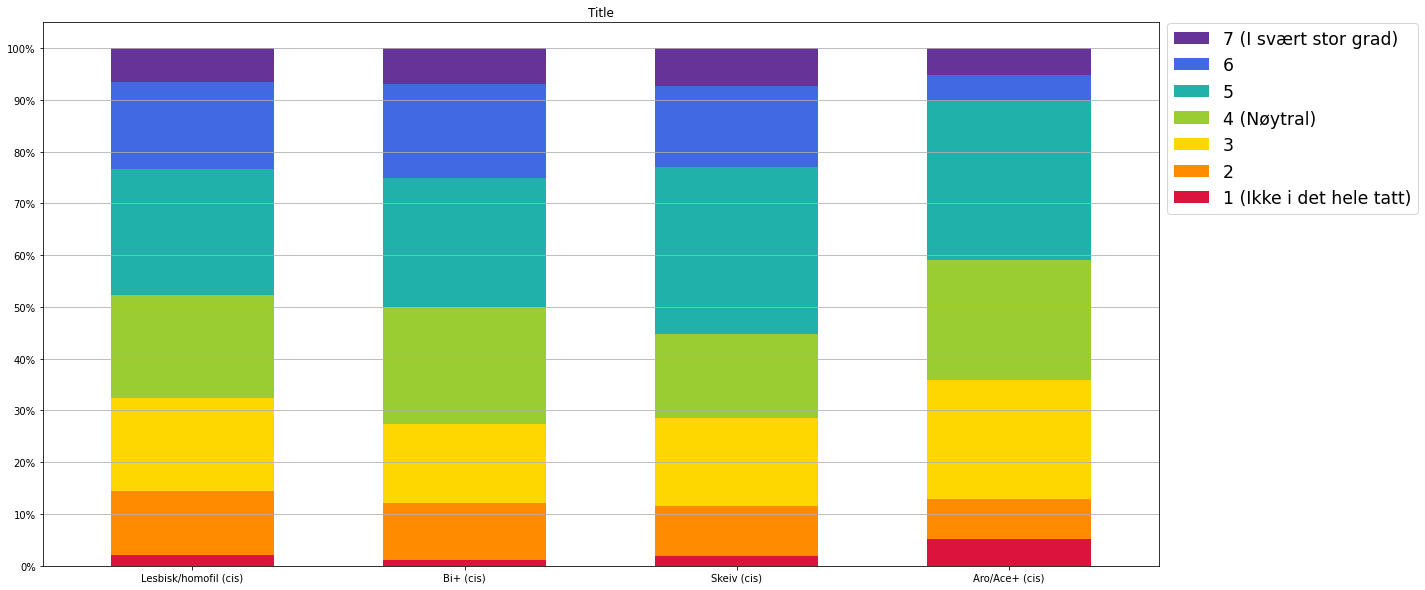

In [83]:
#stacked histogram of group tilfredshet

def plot_group_tilfredshet(groups, plot_all=True, rotation=None, normalize=True, title="Title"):
    """Plot tilfredshet histograms for groups
    
    Each group gets a histogram of responses
    
    Then, a single plot shows all histograms on a single stacked bar chart
    (same information, but denser)
    """
    fractions = {}
    if isinstance(groups, dict):
        iterable = groups.items()
        group_order = list(groups)
        
    else:
        iterable = groups.Overall_tilfredshet
        group_order = None
    
    for name, group in sorted(
        iterable,
        key=lambda name_s: len(name_s[1]),
        reverse=True,
    ):
        if isinstance(groups, dict):
            tilfredshet = group.Overall_tilfredshet
        else:
            tilfredshet = group
        if plot_all:
            plt.figure()
            plot_tilfredshet(name, tilfredshet)
        if "gender_weight" in group.columns:
            weighted_fractions = group.groupby("Overall_tilfredshet").gender_weight.sum()
            weighted_fractions /= weighted_fractions.sum()
            weighted_name = name + " \n(vektet etter kjønn)"
            fractions[weighted_name] = weighted_fractions
            group_order.insert(group_order.index(name)+1, weighted_name)
        if "age_weight" in group.columns:
            weighted_fractions = group.groupby("Overall_tilfredshet").age_weight.sum()
            weighted_fractions /= weighted_fractions.sum()
            weighted_name = name + " \n(vektet etter alder)"
            fractions[weighted_name] = weighted_fractions
            group_order.insert(group_order.index(name), weighted_name)
        #else:
        fractions[name] = tilfredshet.value_counts(normalize=normalize)
            
        
    #cmap = mpl.cm.get_cmap("Spectral", 7)
    fraction_df = pd.DataFrame.from_dict(fractions, orient="index")
    fraction_df = fraction_df.reindex(sorted(fraction_df.columns.astype(int)), axis=1)
    if group_order: 
        fraction_df = fraction_df.reindex(group_order)
    ax = fraction_df.plot(kind='bar', stacked=True, width = .6, color=mycolors, figsize=(20, 10))
    plt.legend(fraction_df.columns[::-1])
    handles, labels = ax.get_legend_handles_labels()
    labels = ["1 (Ikke i det hele tatt)", "2", "3", "4 (Nøytral)", "5", "6", "7 (I svært stor grad)"]
    ax.legend(reversed(handles), reversed(labels), title=None, bbox_to_anchor=(1, 1.015), loc='upper left', fontsize='xx-large')
    plt.grid(False, axis='x')
    plt.grid(True, axis='y')
    marks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    #marks = [0, 30, 60, 90, 120, 150, 180, 210]
    labels = [f"{int(i * 100)}%" for i in marks]
    #labels = [i for i in marks]
    plt.yticks(marks, labels)
    plt.xticks(rotation=rotation)
    plt.title(title)
#   print(fraction_df)
    
#AskMin
plot_group_tilfredshet(cis_LGBQA_groups, normalize = True, plot_all=False)
#plt.ylim(0, 1)

Analysis : Could make several charts with weighted queer group to show that weighting doesn't significantly change the results — weighting isn't possible for this group, but this shows that it wouldn't have a large impact anyway. 


# I made a function!

In [84]:
def plot_some_lines(put_df_here, column_name, kind="line", **kwargs):
    value_counts = put_df_here.groupby("group")[column_name].value_counts(normalize = True).unstack()
    if kind=="line":
        value_counts = value_counts.transpose()
    thicc=value_counts.plot(kind=kind, color=mycolors, **kwargs)
    for line in thicc.get_lines():
        line.set_linewidth(4)
        
def plot_some_lines_and_bars_too(put_df_here, column_name, rotation=None, labels=None):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True, sharey=True)
    plot_some_lines(put_df_here, column_name, ax=axs[0])
    plot_some_lines(put_df_here, column_name, kind="bar", ax=axs[1]) 
    plot_some_lines(put_df_here, column_name, kind="bar", stacked = True, ax=axs[2]) 
    if rotation is not None: 
        axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=rotation)
        axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=rotation)
    
    handles, labels = axs[1].get_legend_handles_labels()
    #axs[1].legend(handles[::-1], labels[::-1], title=None, bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[1].legend(handles[::-1], labels=labels, title=None, bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[2].legend().remove()
    
    
    # Put in instead of "labels[::-1]" — ["Svært enig", "Litt enig", "Nøytral", "Litt uenig", "Svært uenig"]
    
# plot_some_lines_and_bars_too(chcsts_df, "utrygt", rotation=0)
#plot_some_lines(synlighet_df, "Valgt_andre_bib")

In [85]:
#labels = list(results.keys())
#data = np.array(list(np.array(r) for r in results.values()))
#data_cum = data.cumsum(axis=1)
#data


# Plotting answers to Likert-scale agree/disagree questions


In [86]:
# Making a horizontal bar graph for agree - disagree questions

enighetsskala = ["Svært uenig", "Litt uenig", "Nøytral", "Litt enig", "Svært enig",]
hyppighetsskala = ["Aldri", "Sjeldent", "Noen ganger", "Ofte", "Hver gang",]
hendelsesskala = ["Aldri", "Kun under Pride", "Et par ganger", "Noen ganger", "Mange ganger",]
viktighetsskala = ["Ikke viktig i det hele tatt", "Ikke så viktig", "Nøytral / ingen mening", "Litt viktig", "Svært viktig",]
holdningsskala = ["Svært negativ", "Litt negativ", "Nøytral", "Litt positiv", "Svært positiv",]

scales = {
    'UV' : hendelsesskala,
    'UBU' : hendelsesskala,
    'Andre_temaer' : hendelsesskala,
    'Arr' : hendelsesskala,
    
    'utlan' : hyppighetsskala,
    'bla_i' : hyppighetsskala,
    'datamaskin' : hyppighetsskala,
    'still_spm' : hyppighetsskala,
    'utrygt' : hyppighetsskala,
    'm_med_respekt' : hyppighetsskala,
    
    'Holdning_UV' : holdningsskala,
    'Holdning_UBU' : holdningsskala,
    'Holdning_Andre_temaer' : holdningsskala,
    'Holdning_Arr' : holdningsskala,
    
    'Mer_skj_item' : viktighetsskala,
    'Mer_skj_skaper' : viktighetsskala,
    'Mer_skj_mangfold' : viktighetsskala,
    'Mer_faglitt' : viktighetsskala,
    'Mer_BU' : viktighetsskala,
    'Bedre_gjenfinning' : viktighetsskala,
    'Info' : viktighetsskala,
    'Kompetanseheving' : viktighetsskala,
    'Apne_ansatte' : viktighetsskala,
    'Tredje_KI' : viktighetsskala,
    'Selvbestemt_KID' : viktighetsskala,
    'Endre_KID' : viktighetsskala,
    'Toaletter' : viktighetsskala,
    'Pronomen_bruk' : viktighetsskala,
    'Nulltoleranse' : viktighetsskala,
    'Skilting' : viktighetsskala,
}



#     agreement_scale = [
#         "Strongly disagree",
#         "Somewhat disagree",
#         "Neutral",
#         "Somewhat agree",
#         "Strongly agree",
#     ]

# categorical data type for enighet columns
# ensures value_counts() returns 0 for categories with no responses
enighet_category = pd.CategoricalDtype([-2, -1, 0, 1, 2], ordered=True)


def enighet(df, columns, title=None, group_order=None):
    """

    Plot enighet bars for all groups

    Parameters
    ----------
    df : DataFrame (e.g. created with regroup()) or group dict of dataframes
    columns : list of str
        The column(s) to plot for each group
    """
    if isinstance(columns, str):
    # allow columns to be a single column name
        columns = [columns]
    column = columns[0]   
    scale = scales.get(column, enighetsskala)
    if title is None:
        title = ", ".join(columns)
    # create a dict of {'group name': subset_df for just that group}
    if isinstance(df, dict):
        groups = df
    elif "group" in df.columns:
        groups = {}
        for cat in df.group.dtype.categories:
            groups[cat] = df[df.group == cat]
    else:
        # no groups given, use just one group
        groups = {"": df}

    #Different sorting options    
    if group_order == 'ce_descending':
        def count_enig(key):
            series = groups[key][columns[0]]
            return 1.0 * (((series == 2).sum()) + (series == 1).sum()) / len(series.dropna())

        group_order = sorted(groups.keys(), key=count_enig, reverse=True)
        #title = f"{title}\n (Sortert etter sterk enighet i synkende rekkefølge)"
    
    elif group_order == 'se_descending':
        def count_svært_enig(key):
            series = groups[key][columns[0]]
            return 1.0 * (series == 2).sum() / len(series.dropna())

        group_order = sorted(groups.keys(), key=count_svært_enig, reverse=True)
        #title = f"{title}\n (Sortert etter enighet (litt + svært enig) i synkende rekkefølge)"
    
    elif group_order == 'cu_descending':
        def count_enig(key):
            series = groups[key][columns[0]]
            return 1.0 * (((series == -2).sum()) + (series == -1).sum()) / len(series.dropna())

        group_order = sorted(groups.keys(), key=count_enig, reverse=True)
        #title = f"{title}\n (Sortert etter sterk enighet i synkende rekkefølge)"
    
    elif group_order == 'su_descending':
        def count_svært_enig(key):
            series = groups[key][columns[0]]
            return 1.0 * (series == -2).sum() / len(series.dropna())

        group_order = sorted(groups.keys(), key=count_svært_enig, reverse=True)
        #title = f"{title}\n (Sortert etter enighet (litt + svært enig) i synkende rekkefølge)"
    
    if group_order:
        iterable = [(key, groups[key]) for key in group_order]
    else:
        iterable = groups.items()
    
    
    
    # construc the results dict
    # with 5 numbers for each combination of group + column
    results = {}
    nice_column_names = {
        "Jeg bruker ikke folkebibliotek fordi at jeg ikke \nføler meg velkommen der som en skeiv/LHBTIQ+ person" : 'Ikke_velkommen',
        "Jeg ville brukt biblioteket om jeg var sikker på \nat det ville være et trygt rom for meg som skeiv/LHBTIQ+ person" : 'Trygge_rom_pers_IB',
    }
    # reorder these `for...` lines to switch whether questions or groups
    for column in columns:
        for group, group_df in iterable:
            nice_column = nice_column_names.get(column, column)
            label = group
            if len(group_df) <= 20:
                label += "*"
            label = f"{label} \n (N={len(group_df[column].dropna())})"
            if len(columns) > 1:
                label = f"{nice_column} {label}"
            # group_df[column] means get that column for that group
            # the rest is turn it into 5 numbers for the fractional value counts
            results[label] = (
                group_df[column]
                .astype(enighet_category)
                .value_counts(normalize=True)
                .sort_index()
                .array
            )

    # from this point on, the rest of the function is unchanged
    labels = list(results.keys())
    # Line below = "value counts array"
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap("RdYlGn")(np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(15, 8))
    ax.title.set_text(title)
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(scale, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5, label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = "black"  # if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            if c > .04:
                size=16
            elif c < .02:
                continue
            else:
                size=12
            ax.text(
                    x,
                    y,
                    str(int(c * 100)) + "%",
                    ha="center",
                    va="center",
                    color=text_color, 
                    size=size
            )
    ax.legend(
        ncol=len(scale),
        fancybox=True,
        bbox_to_anchor=(0.5, -0.1),
        loc="lower center",
        fontsize="x-large",
    )

    return fig, ax


cishet_skeive = {
    "cis-heterofile": cis_heterofile,
    "skeive": alle_skeive,
}
cishet_skeive_df = regroup(cishet_skeive)

#enighet(gender_stuff_groups, ["Arr"], group_order=None)




In [87]:
# # Making a horizontal bar graph for agree - disagree questions

# enighetsskala = [
#    "Svært uenig",
#    "Litt uenig",
#    "Nøytral",
#     "Litt enig",
#     "Svært enig",
# ]

# hyppighetsskala = [
#     "Aldri",
#     "Sjeldent",
#     "Noen ganger",
#     "Ofte",
#     "Hver gang",
# ]

# #     agreement_scale = [
# #         "Strongly disagree",
# #         "Somewhat disagree",
# #         "Neutral",
# #         "Somewhat agree",
# #         "Strongly agree",
# #     ]

# # categorical data type for enighet columns
# # ensures value_counts() returns 0 for categories with no responses
# enighet_category = pd.CategoricalDtype([-2, -1, 0, 1, 2], ordered=True)


# def enighet(df, columns, title=None, group_order=None):
#     """

#     Plot enighet bars for all groups

#     Parameters
#     ----------
#     df : DataFrame (e.g. created with regroup()) or group dict of dataframes
#     columns : list of str
#         The column(s) to plot for each group
#     """
#     if isinstance(columns, str):
#     # allow columns to be a single column name
#         columns = [columns]

#     if title is None:
#         title = ", ".join(columns)
#     # create a dict of {'group name': subset_df for just that group}
#     if isinstance(df, dict):
#         groups = df
#     elif "group" in df.columns:
#         groups = {}
#         for cat in df.group.dtype.categories:
#             groups[cat] = df[df.group == cat]
#     else:
#         # no groups given, use just one group
#         groups = {"": df}

#     #Different sorting options    
#     if group_order == 'ce_descending':
#         def count_enig(key):
#             series = groups[key][columns[0]]
#             return 1.0 * (((series == 2).sum()) + (series == 1).sum()) / len(series.dropna())

#         group_order = sorted(groups.keys(), key=count_enig, reverse=True)
#         #title = f"{title}\n (Sortert etter sterk enighet i synkende rekkefølge)"
    
#     elif group_order == 'se_descending':
#         def count_svært_enig(key):
#             series = groups[key][columns[0]]
#             return 1.0 * (series == 2).sum() / len(series.dropna())

#         group_order = sorted(groups.keys(), key=count_svært_enig, reverse=True)
#         #title = f"{title}\n (Sortert etter enighet (litt + svært enig) i synkende rekkefølge)"
    
#     elif group_order == 'cu_descending':
#         def count_enig(key):
#             series = groups[key][columns[0]]
#             return 1.0 * (((series == -2).sum()) + (series == -1).sum()) / len(series.dropna())

#         group_order = sorted(groups.keys(), key=count_enig, reverse=True)
#         #title = f"{title}\n (Sortert etter sterk enighet i synkende rekkefølge)"
    
#     elif group_order == 'su_descending':
#         def count_svært_enig(key):
#             series = groups[key][columns[0]]
#             return 1.0 * (series == -2).sum() / len(series.dropna())

#         group_order = sorted(groups.keys(), key=count_svært_enig, reverse=True)
#         #title = f"{title}\n (Sortert etter enighet (litt + svært enig) i synkende rekkefølge)"
    
#     if group_order:
#         iterable = [(key, groups[key]) for key in group_order]
#     else:
#         iterable = groups.items()
    
    
    
#     # construc the results dict
#     # with 5 numbers for each combination of group + column
#     results = {}
#     nice_column_names = {
#         "Jeg bruker ikke folkebibliotek fordi at jeg ikke \nføler meg velkommen der som en skeiv/LHBTIQ+ person" : 'Ikke_velkommen',
#         "Jeg ville brukt biblioteket om jeg var sikker på \nat det ville være et trygt rom for meg som skeiv/LHBTIQ+ person" : 'Trygge_rom_pers_IB',
#     }
#     # reorder these `for...` lines to switch whether questions or groups
#     for column in columns:
#         for group, group_df in iterable:
#             nice_column = nice_column_names.get(column, column)
#             label = group
#             if len(group_df) <= 20:
#                 label += "*"
#             label = f"{label} \n (N={len(group_df[column].dropna())})"
#             if len(columns) > 1:
#                 label = f"{nice_column} {label}"
#             # group_df[column] means get that column for that group
#             # the rest is turn it into 5 numbers for the fractional value counts
#             results[label] = (
#                 group_df[column]
#                 .astype(enighet_category)
#                 .value_counts(normalize=True)
#                 .sort_index()
#                 .array
#             )

#     # from this point on, the rest of the function is unchanged
#     labels = list(results.keys())
#     # Line below = "value counts array"
#     data = np.array(list(results.values()))
#     data_cum = data.cumsum(axis=1)
#     category_colors = plt.get_cmap("RdYlGn")(np.linspace(0.15, 0.85, data.shape[1]))

#     fig, ax = plt.subplots(figsize=(15, 8))
#     ax.title.set_text(title)
#     ax.invert_yaxis()
#     ax.xaxis.set_visible(False)
#     ax.set_xlim(0, np.sum(data, axis=1).max())

#     for i, (colname, color) in enumerate(zip(enighetsskala, category_colors)):
#         widths = data[:, i]
#         starts = data_cum[:, i] - widths
#         ax.barh(labels, widths, left=starts, height=0.5, label=colname, color=color)
#         xcenters = starts + widths / 2

#         r, g, b, _ = color
#         text_color = "black"  # if r * g * b < 0.5 else 'darkgrey'
#         for y, (x, c) in enumerate(zip(xcenters, widths)):
#             if c > .04:
#                 size=16
#             elif c < .02:
#                 continue
#             else:
#                 size=12
#             ax.text(
#                     x,
#                     y,
#                     str(int(c * 100)) + "%",
#                     ha="center",
#                     va="center",
#                     color=text_color, 
#                     size=size
#             )
#     ax.legend(
#         ncol=len(enighetsskala),
#         fancybox=True,
#         bbox_to_anchor=(0.5, -0.1),
#         loc="lower center",
#         fontsize="x-large",
#     )

#     return fig, ax


# cishet_skeive = {
#     "cis-heterofile": cis_heterofile,
#     "skeive": alle_skeive,
# }
# cishet_skeive_df = regroup(cishet_skeive)

# enighet(gender_stuff_groups, ["Minoritetsstress_brukere"], group_order=None)

In [88]:
#enighet(queer_non_users, ["Trygge_rom_pers_IB", "Ikke_velkommen"], group_order=None)

In [89]:
def plot_group_column(groups, column="Overall_tilfredshet", plot_all=True, rotation=None, low_is_bad=True, group_order=None, title="title", labels=["1 (Ikke i det \n   hele tatt)", "2", "3", "4 (Nøytral)", "5", "6", "7 (I svært \n   stor grad)"]):

    counts = {}
    
    fractions = {}
    if isinstance(groups, dict):
        iterable = groups.items()
        group_order = list(groups)
        
    else:
        iterable = groups[column]
    
    for name, group in sorted(
        iterable,
        key=lambda name_s: len(name_s[1]),
        reverse=True,
    ):
        if isinstance(groups, dict):
            series = group[column]
        else:
            series = group
        counts[name] = len(series.dropna())
        if len(series.dropna()):    
            fractions[name] = series.value_counts(normalize=True)
        else:
            if group_order: 
                group_order.remove(name)
        
    #cmap = mpl.cm.get_cmap("Spectral", 7)
    fraction_df = pd.DataFrame.from_dict(fractions, orient="index")
    fraction_df = fraction_df.reindex(sorted(fraction_df.columns.astype(int)), axis=1)
    if group_order: 
        fraction_df = fraction_df.reindex(group_order)
    if low_is_bad:
        colors=mycolors
    else:
        colors=mycolors[::-1]
    ax = fraction_df.plot(kind='bar', stacked=True, color=colors)
    plt.legend(fraction_df.columns[::-1])
    handles, existing_labels = ax.get_legend_handles_labels() 
    ax.legend(reversed(handles), reversed(labels), title=None, fontsize='x-large', bbox_to_anchor=(1.015, 1.015), loc='upper left')
    plt.grid(False, axis='x')
    plt.grid(True, axis='y')
    marks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    labels = [f"{int(i * 100)}%" for i in marks]
    plt.yticks(marks, labels)
    xlabels=[]
    for name in group_order:
        xlabels.append(f"{name} \n (N={counts[name]})")
    locs, labels = plt.xticks()  # Get the current locations and labels.
    plt.xticks(locs, xlabels, rotation=rotation)
    plt.title(title)
#   print(fraction_df)

#plot_group_column(all_the_queers, column="Alltid_velkommen", plot_all=True, rotation=None, low_is_bad=True, group_order=None, title="title", labels=["1 (Ikke i det hele tatt)", "2", "3", "4 (Nøytral)", "5", "6", "7 (I svært stor grad)"])



In [90]:
orientation_names ={
    "Ace" : "Ace-spekter",
    "LG" : "Homofil eller lesbisk",
    "Bi" : "Ikke-monoseksuell \n (bifil, panfil mm.)",
    "Fluid" : "Flytende",
    "Het" : "Heterofil",
    "Q" : "Skeiv",
    "SU" : "Søkende/usikker",
    "NONE" : "Ingen av svaralternativene passer"
}


def orientation_venn(O1="Ace", O2="Bi", O3="LG"):
    O1_venn = sum(df.Seksuell_orientering.str.contains(O1))
    O2_venn = sum(df.Seksuell_orientering.str.contains(O2))
    top_int = (df.Seksuell_orientering.str.contains(O1) & df.Seksuell_orientering.str.contains(O2)).sum()
    if O3:
        left_int = (df.Seksuell_orientering.str.contains(O1) & df.Seksuell_orientering.str.contains(O3)).sum()
        right_int = (df.Seksuell_orientering.str.contains(O2) & df.Seksuell_orientering.str.contains(O3)).sum()
        middle_int = (df.Seksuell_orientering.str.contains(O2) & df.Seksuell_orientering.str.contains(O3) & df.Seksuell_orientering.str.contains(O1)).sum()
        O3_venn = sum(df.Seksuell_orientering.str.contains(O3))

    plt.figure(figsize=(10,10))
    
    if not O3:
        c = venn2(subsets = (O1_venn, O2_venn, top_int), alpha = 0.7, set_labels = (orientation_names[O] for O in (O1, O2)))
        c.get_patch_by_id('10').set_color('Crimson')
        c.get_patch_by_id('01').set_color('Gold')
        c.get_patch_by_id('11').set_color('DarkOrange')
    else:
        c = venn3(subsets = (O1_venn, O2_venn, top_int, O3_venn, left_int, right_int, middle_int), alpha = 0.7, set_labels = (orientation_names[O] for O in (O1, O2, O3))) # 7-element list of subset sizes
        c.get_patch_by_id('100').set_color('Crimson')
        c.get_patch_by_id('010').set_color('Gold')
        c.get_patch_by_id('001').set_color('RoyalBlue')
        patch = c.get_patch_by_id('110')
        if patch:
            patch.set_color('DarkOrange')
        patch = c.get_patch_by_id('011')
        if patch:
            patch.set_color('YellowGreen')
        patch = c.get_patch_by_id('101')
        if patch:
            patch.set_color('RebeccaPurple')
        patch = c.get_patch_by_id('111')
        if patch:
            patch.set_color('RosyBrown')

    #c.get_patch_by_id('01').set_alpha(1.3)
    plt.title("Overlappende orienteringer \n", fontsize=20)
    for text in c.set_labels:
        if text:
            text.set_fontsize(18)
    for text in c.subset_labels:
        if text:
            text.set_fontsize(18)
    plt.show()
    #the first element is the size of the set on the left
    #the second element is the size of the set on the right
    #the third element is the size of the overlap between the left and right sets
    #the fourth element is the size of the set on the bottom
    #the fifth element is the size of the overlap between the left and bottom sets
    #the sixth element is the size of the overlap between the right and bottom sets
    #and the seventh element is the size of the overlap between all three sets.
    
    #To adjust the labels in the venn:
    #c.get_label_by_id("011").set_x(0.08)
    #c.get_label_by_id("100").set_x(-0.4)
    #c.get_label_by_id("100").set_y(0.2)
    #c.get_label_by_id("010").set_y(0.3)
    #c.get_label_by_id("010").set_x(0.25)
    #c.get_label_by_id("001").set_x(-0.1)
    #c.get_label_by_id("001").set_y(-0.4)
    #c.get_label_by_id("101").set_y(0.005)
    #c.get_label_by_id("111").set_x(-0.145)
    #c.get_label_by_id("111").set_y(0.03)
    
#orientation_venn("Q", "Bi", "Ace")

In [91]:
# # Making a horizontal bar graph that works for all questions and multiple questions OR multiple groups

# #category of scale
# five_pt = pd.CategoricalDtype([-2, -1, 0, 1, 2], ordered=True)
# seven_pt = pd.CategoricalDtype([1, 2, 3, 4, 5, 6, 7], ordered=True)

# #scale (labels for legend)
# enighetsskala = ["Svært uenig", "Litt uenig", "Nøytral", "Litt enig", "Svært enig",]
# hyppighetsskala = ["Aldri", "Sjeldent", "Noen ganger", "Ofte", "Hver gang",]
# hendelsesskala = ["Aldri", "Kun under Pride", "Et par ganger", "Noen ganger", "Mange ganger",]
# viktighetsskala = ["Ikke viktig i det hele tatt", "Ikke så viktig", "Nøytral / ingen mening", "Litt viktig", "Svært viktig",]
# holdningsskala = ["Svært negativ", "Litt negativ", "Nøytral", "Litt positiv", "Svært positiv",]
# tilfredshetsskala = ["Ikke i det \nhele tatt", "2", "3", "Nøytral", "5", "6", "I svært \nstor grad"]

# scales = {
#     'UV' : (hendelsesskala, five_pt),
#     'UBU' : (hendelsesskala, five_pt),
#     'Andre_temaer' : (hendelsesskala, five_pt),
#     'Arr' : (hendelsesskala, five_pt),
    
#     'utlan' : (hyppighetsskala, five_pt),
#     'bla_i' : (hyppighetsskala, five_pt),
#     'datamaskin' : (hyppighetsskala, five_pt),
#     'still_spm' : (hyppighetsskala, five_pt),
#     'utrygt' : (hyppighetsskala, five_pt),
#     'm_med_respekt' : (hyppighetsskala, five_pt),
    
#     'Holdning_UV' : (holdningsskala, five_pt),
#     'Holdning_UBU' : (holdningsskala, five_pt),
#     'Holdning_Andre_temaer' : (holdningsskala, five_pt),
#     'Holdning_Arr' : (holdningsskala, five_pt),
    
#     'Mer_skj_item' : (holdningsskala, five_pt),
#     'Mer_skj_skaper' : (holdningsskala, five_pt),
#     'Mer_skj_mangfold' : (holdningsskala, five_pt),
#     'Mer_faglitt' : (holdningsskala, five_pt),
#     'Mer_BU' : (holdningsskala, five_pt),
#     'Bedre_gjenfinning' : (holdningsskala, five_pt),
#     'Info' : (holdningsskala, five_pt),
#     'Kompetanseheving' : (holdningsskala, five_pt),
#     'Apne_ansatte' : (holdningsskala, five_pt),
#     'Tredje_KI' : (holdningsskala, five_pt),
#     'Selvbestemt_KID' : (holdningsskala, five_pt),
#     'Endre_KID' : (holdningsskala, five_pt),
#     'Toaletter' : (holdningsskala, five_pt),
#     'Pronomen_bruk' : (holdningsskala, five_pt),
#     'Nulltoleranse' : (holdningsskala, five_pt),
#     'Skilting' : (holdningsskala, five_pt),
    
#     "Overall_tilfredshet" : (tilfredshetsskala, seven_pt, True),
#     "Overall_behov_KH" : (tilfredshetsskala, seven_pt),
#     "Individ_behov_KH" : (tilfredshetsskala, seven_pt),
#     "Interesse_KH" : (tilfredshetsskala, seven_pt),
#     "Behov_kompetanseheving" : (tilfredshetsskala, seven_pt, False),
    
#     'Utvalg_KID' : (enighetsskala, five_pt, True),
#     'Utvalg_Orientering' : (enighetsskala, five_pt, True),
#     'Utvalg_Intersex' : (enighetsskala, five_pt, True),
#     'Utvalg_lykkelig' : (enighetsskala, five_pt, True),
#     'Utvalg_fag' : (enighetsskala, five_pt, True),
#     'Aldri_tenkt' : (enighetsskala, five_pt, True),
#     'Utrygt_stille_spm' : (enighetsskala, five_pt, True),
#     'Rep_matters_B' : (enighetsskala, five_pt, True),
#     'Bib_pleier_ha' : (enighetsskala, five_pt, True),
#     'Alltid_velkommen' : (enighetsskala, five_pt, True),
#     'Trygge_rom_gen_B' : (enighetsskala, five_pt, True),
#     'Ingen_rolle' : (enighetsskala, five_pt, True),
#     'Ingenting_tilby' : (enighetsskala, five_pt, True),
#     'Bibs_ansvar' : (enighetsskala, five_pt, True),
#     'Minoritetsstress_ansatte' : (enighetsskala, five_pt, True),
#     'Minoritetsstress_brukere' : (enighetsskala, five_pt, True),
#     'Lhbtiq_vennlig' : (enighetsskala, five_pt, True),
#     'Rom_for_forbedring' : (enighetsskala, five_pt, True),
#     'Andre_brukere' : (enighetsskala, five_pt, True),
#     'Helt_meg_selv' : (enighetsskala, five_pt, True),
#     'Ikke_velkommen' : (enighetsskala, five_pt, True),
#     'Ingen_rolle_IB' : (enighetsskala, five_pt, True),
#     'Trygge_rom_pers_IB' : (enighetsskala, five_pt, True),
#     'Trygge_rom_gen_IB' : (enighetsskala, five_pt, True),
#     'Godt_utvalg' : (enighetsskala, five_pt, True),
#     'Skeiv_medieforbruk_pos' : (enighetsskala, five_pt, True),
#     'Skeiv_medieforbruk_neg' : (enighetsskala, five_pt, True),
#     'Rep_matters_IB' : (enighetsskala, five_pt, True),
#     'Rep_matters_all' : (enighetsskala, five_pt, True),
#     'Trygge_rom_gen_all' :(enighetsskala, five_pt, True),

# }

# #enighet_category = pd.CategoricalDtype([-2, -1, 0, 1, 2], ordered=True)
# #tilfredshet_category = pd.CategoricalDtype([1, 2, 3, 4, 5, 6, 7], ordered=True)


# # categorical data type for enighet columns
# # ensures value_counts() returns 0 for categories with no responses


# def hbar_scales(df, columns, title=None, group_order=None):
#     """

#     Plot enighet bars for all groups

#     Parameters
#     ----------
#     df : DataFrame (e.g. created with regroup()) or group dict of dataframes
#     columns : list of str
#         The column(s) to plot for each group
#     """
#     if isinstance(columns, str):
#     # allow columns to be a single column name
#         columns = [columns]
#     column = columns[0]   
    
#     scale, category, low_is_bad = scales.get(column)
    
#     if title is None:
#         title = ", ".join(columns)
#     # create a dict of {'group name': subset_df for just that group}
#     if isinstance(df, dict):
#         groups = df
#     elif "group" in df.columns:
#         groups = {}
#         for cat in df.group.dtype.categories:
#             groups[cat] = df[df.group == cat]
#     else:
#         # no groups given, use just one group
#         groups = {"": df}

#     #Different sorting options    
#     if group_order == 'ce_descending':
#         def count_enig(key):
#             series = groups[key][columns[0]]
#             return 1.0 * (((series == 2).sum()) + (series == 1).sum()) / len(series.dropna())

#         group_order = sorted(groups.keys(), key=count_enig, reverse=True)
#         #title = f"{title}\n (Sortert etter sterk enighet i synkende rekkefølge)"
    
#     elif group_order == 'se_descending':
#         def count_svært_enig(key):
#             series = groups[key][columns[0]]
#             return 1.0 * (series == 2).sum() / len(series.dropna())

#         group_order = sorted(groups.keys(), key=count_svært_enig, reverse=True)
#         #title = f"{title}\n (Sortert etter enighet (litt + svært enig) i synkende rekkefølge)"
    
#     elif group_order == 'cu_descending':
#         def count_enig(key):
#             series = groups[key][columns[0]]
#             return 1.0 * (((series == -2).sum()) + (series == -1).sum()) / len(series.dropna())

#         group_order = sorted(groups.keys(), key=count_enig, reverse=True)
#         #title = f"{title}\n (Sortert etter sterk enighet i synkende rekkefølge)"
    
#     elif group_order == 'su_descending':
#         def count_svært_enig(key):
#             series = groups[key][columns[0]]
#             return 1.0 * (series == -2).sum() / len(series.dropna())

#         group_order = sorted(groups.keys(), key=count_svært_enig, reverse=True)
#         #title = f"{title}\n (Sortert etter enighet (litt + svært enig) i synkende rekkefølge)"
    
#     if group_order:
#         iterable = [(key, groups[key]) for key in group_order]
#     else:
#         iterable = groups.items()
    
    
    
#     # construc the results dict
#     # with 5 numbers for each combination of group + column
#     results = {}
#     nice_column_names = {
#         "Jeg bruker ikke folkebibliotek fordi at jeg ikke \nføler meg velkommen der som en skeiv/LHBTIQ+ person" : 'Ikke_velkommen',
#         "Jeg ville brukt biblioteket om jeg var sikker på \nat det ville være et trygt rom for meg som skeiv/LHBTIQ+ person" : 'Trygge_rom_pers_IB',
#     }
#     # reorder these `for...` lines to switch whether questions or groups
    
#     for column in columns:
#         for group, group_df in iterable:
#             nice_column = nice_column_names.get(column, column)
#             label = group
#             if len(group_df) <= 20:
#                 label += "*"
#             label = f"{label} \n (N={len(group_df[column].dropna())})"
#             if len(columns) > 1:
#                 label = f"{nice_column} {label}"
#             # group_df[column] means get that column for that group
#             # the rest is turn it into 5 numbers for the fractional value counts
#             results[label] = (
#                 group_df[column]
#                 .astype(category)
#                 .value_counts(normalize=True)
#                 .sort_index()
#                 .array
#             )
        
#     # from this point on, the rest of the function is unchanged
#     labels = list(results.keys())
#     # Line below = "value counts array"
#     data = np.array(list(results.values()))
#     data_cum = data.cumsum(axis=1)
    
#     if len(scale) == 5:
#         category_colors = plt.get_cmap("RdYlGn")(np.linspace(0.15, 0.85, data.shape[1]))
#     elif len(scale) == 7:
#         if low_is_bad == True:
#             category_colors=mycolors
#         else:
#             category_colors=mycolors[::-1]

#     fig, ax = plt.subplots(figsize=(15, 8))
#     ax.title.set_text(title)
#     ax.invert_yaxis()
#     ax.xaxis.set_visible(False)
#     ax.set_xlim(0, np.sum(data, axis=1).max())

#     for i, (colname, color) in enumerate(zip(scale, category_colors)):
#         widths = data[:, i]
#         starts = data_cum[:, i] - widths
#         ax.barh(labels, widths, left=starts, height=0.5, label=colname, color=color)
#         xcenters = starts + widths / 2

#   #      r, g, b, _ = color
#         text_color = "black"  # if r * g * b < 0.5 else 'darkgrey'
#         for y, (x, c) in enumerate(zip(xcenters, widths)):
#             if c > .04:
#                 size=16
#             elif c < .02:
#                 continue
#             else:
#                 size=12
#             ax.text(
#                     x,
#                     y,
#                     str(int(c * 100)) + "%",
#                     ha="center",
#                     va="center",
#                     color=text_color, 
#                     size=size
#             )
#     ax.legend(
#         ncol=len(scale),
#         fancybox=True,
#         bbox_to_anchor=(0.5, -0.15),
#         loc="lower center",
#         fontsize="x-large",
#     )

#     return fig, ax


# cishet_skeive = {
#     "cis-heterofile": cis_heterofile,
#     "skeive": alle_skeive,
# }
# cishet_skeive_df = regroup(cishet_skeive)

# #hbar_scales(LGBTQIA_groups, ["Lhbtiq_vennlig"], group_order=None)

^Analysis: 63% were familiar with the SIAN issue/debate, 35% ja, påvirket oppfatning av bib som trygt rom, 35% nei, 29% usikker. Look into how many pos. vs. neg.

In [92]:
# regions = alle_skeive.Region.unique()
# for iterable in regions:
#     fraction = sum(alle_skeive.Region == iterable)
#     total = len(alle_skeive)
#     print(iterable, ":", "{:.1%}".format(fraction/total))

In [93]:
# regions = cis_heterofile.Region.unique()
# for iterable in regions:
#     fraction = sum(cis_heterofile.Region == iterable)
#     total = len(cis_heterofile)
#     print(iterable, ":", "{:.1%}".format(fraction/total))

In [94]:
# genders = alle_skeive.Kjonnsidentitet.unique()
# for iterable in genders:
#     fraction = sum(alle_skeive.Kjonnsidentitet == iterable)
#     total = len(alle_skeive)
#     print(iterable, ":", "{:.1%}".format(fraction/total))

In [95]:
# genders = cis_heterofile.Kjonnsidentitet.unique()
# for iterable in genders:
#     fraction = sum(cis_heterofile.Kjonnsidentitet == iterable)
#     total = len(cis_heterofile)
#     print(iterable, ":", "{:.1%}".format(fraction/total))

In [96]:
# ages = cis_heterofile.Alder.unique()
# for iterable in ages:
#     fraction = sum(cis_heterofile.Alder == iterable)
#     total = len(cis_heterofile)
#     print(iterable, ":", "{:.1%}".format(fraction/total))

In [97]:
#     ages = alle_skeive.Alder.unique()
#     for iterable in ages:
#         fraction = sum(alle_skeive.Alder == iterable)
#         total = len(alle_skeive)
#         print(iterable, ":", "{:.1%}".format(fraction/total))